# QAOA and QAA to solve a QUBO problem

In [1]:
from copy import copy
import numpy as np
import matplotlib.pyplot as plt
import pulser
import pulser_simulation
from scipy.optimize import minimize
from scipy.spatial.distance import pdist, squareform

## Introduction

In this tutorial, we illustrate how to solve a Quadratic Unconstrained Binary Optimization (QUBO) instance using an ensemble of Rydberg atoms in analog mode.

QUBO has been extensively studied [Glover, et al., 2018](https://arxiv.org/pdf/1811.11538.pdf) and is used to model and solve numerous categories of optimization problems including important instances of network flows, scheduling, max-cut, max-clique, vertex cover and other graph and management science problems, integrating them into a unified modeling framework.

Mathematically, a QUBO instance consists of a symmetric matrix $Q$ of size $(N \times N)$, and the optimization problem associated with it is to find the bitstring $z=(z_1, \dots, z_N) \in \{0, 1 \}^N$ that minimizes the quantity
$$f(z) = z^{T}Qz$$ 

Suppose we are given the following QUBO matrix $Q$:

In [2]:
Q = np.array(
    [
        [-10.0, 19.7365809, 19.7365809, 5.42015853, 5.42015853],
        [19.7365809, -10.0, 20.67626392, 0.17675796, 0.85604541],
        [19.7365809, 20.67626392, -10.0, 0.85604541, 0.17675796],
        [5.42015853, 0.17675796, 0.85604541, -10.0, 0.32306662],
        [5.42015853, 0.85604541, 0.17675796, 0.32306662, -10.0],
    ]
)

In this tutorial, we will demonstrate how this QUBO instance can be mapped and solved using neutral atoms. For reasons that will become apparent further along, this QUBO instance is particularly amenable to embedding on a neutral-atom device since:

1. All the off-diagonal terms are positive.
2. The diagonal terms are all equal.

Furthermore, because the QUBO is small, we can classically check all solutions and mark the optimal ones. This will help us later in the tutorial to visualize the quality of our quantum approach.

In [3]:
bitstrings = [np.binary_repr(i, len(Q)) for i in range(2 ** len(Q))]
costs = []
# this takes exponential time with the dimension of the QUBO
for b in bitstrings:
    z = np.array(list(b), dtype=int)
    cost = z.T @ Q @ z
    costs.append(cost)
zipped = zip(bitstrings, costs)
sort_zipped = sorted(zipped, key=lambda x: x[1])
print(sort_zipped[:3])

[('00111', -27.288260020000003), ('01011', -27.288260020000003), ('00101', -19.64648408)]


This QUBO admits `01011` and `00111` as optimal solutions.

## Solving the QUBO with `Pulser` 

Let's recall that Pulser enables you to program the Ising Hamiltonian $H_Q$:

$$\frac{H_Q}{\hbar}(t) = \sum_{k=1}^N \left (\frac{\Omega(t)}{2} e^{-i\phi(t)} |g\rangle\langle r|_k + \frac{\Omega(t)}{2} e^{i\phi(t)} |r\rangle\langle g|_k - \delta(t) |r\rangle\langle r|_k + \sum_{j<k}\frac{C_6}{\hbar R_{kj}^6} \hat{n}_k \hat{n}_j \right)
$$

The key idea is to encode the off-diagonal terms of $Q$ by using the Rydberg interaction between atoms: 
$$\left[\frac{C_6}{\hbar R_{kj}^6}\right]_{1\leq k, j \leq N}\leftrightarrow Q_{off-diagonal}$$

Since the Rydberg interaction depends on the pairwise distance between atoms $k$ and $j$, $R_{kj}$, this will define the `Register` of atoms to use in the computation.

The second idea is to find the optimal solution of the QUBO by preparing the ground-state of $H_Q$ and outputing the optimal bitstrings. There are multiple approaches to prepare the ground-state of an Hamiltonian. We will here use the Quantum Adiabatic Algorithm (QAA), that is the most suited for cold-atom quantum computers. 

<div class="alert alert-info">

**Note**:

1. The Rydberg interaction is strictly positive, which is why it matters that our off-diagonal terms are too.
2. The diagonal terms of $Q$ are understood as a detuning to apply on each atom. Since the diagonal terms are all the same, we can use the same detuning  $\delta$ for all the atoms. If that was not the case, some kind of local addressability capabilities would be necessary (see [this tutorial](./tutorials/mwis.nblink))

</div>



 

### 1. Pick a Device

To implement the Hamiltonian $H_Q$, we need a `Device` containing a `Rydberg.Global` channel. `pulser.AnalogDevice` and `pulser.DigitalAnalogDevice` are examples of `Devices` that contain a `Rydberg.Global` channel. Since the durations of the pulses will be quite long, let's use `pulser.DigitalAnalogDevice` since it allows the creation of longer sequences.

In [4]:
device = pulser.DigitalAnalogDevice
device.print_specs()

----------------------------------
DigitalAnalogDevice Specifications
----------------------------------
A device with digital and analog capabilites.

Register parameters:
 - Dimensions: 2D
 - Maximum number of atoms: 100
 - Maximum distance from origin: 50 µm
 - Minimum distance between neighbouring atoms: 4 μm

Layout parameters:
 - Requires layout: Yes
 - Accepts new layout: Yes
 - Minimal number of traps: 1
 - Maximum layout filling fraction: 0.5

Device parameters:
 - Rydberg level: 70
 - Ising interaction coefficient: 5420158.53
 - Channels can be reused: No
 - Supported bases: ground-rydberg, digital
 - Supported states: r, g, h
 - SLM Mask: Yes

Channels:
 - 'rydberg_global': Rydberg(addressing='Global', max_abs_detuning=125.66370614359172, max_amp=15.707963267948966, min_retarget_interval=None, fixed_retarget_t=None, max_targets=None, clock_period=4, min_duration=16, max_duration=67108864, min_avg_amp=0, mod_bandwidth=None, custom_phase_jump_time=None, eom_config=None, propag

### 2. Create the Register

Let's attempt a simple minimization procedure to find the optimal positions of the atoms in the Register that replicate best the off-diagonal terms of $Q$:

In [5]:
def evaluate_mapping(
    new_coords: np.ndarray, Q: np.ndarray, device: pulser.devices.Device
):
    """Cost function to minimize. Ideally, the pairwise distances are conserved."""
    new_coords = np.reshape(new_coords, (len(Q), 2))
    # computing the matrix of the distances between all coordinate pairs
    new_Q = squareform(device.interaction_coeff / pdist(new_coords) ** 6)
    return np.linalg.norm(new_Q - Q)

In [6]:
costs = []
np.random.seed(0)
x0 = np.random.random(len(Q) * 2)
res = minimize(
    evaluate_mapping,
    x0,
    args=(Q, device),
    method="Nelder-Mead",
    tol=1e-6,
    options={"maxiter": 200000, "maxfev": None},
)
coords = np.reshape(res.x, (len(Q), 2))

We can then build the `Register` from the obtained coordinates:

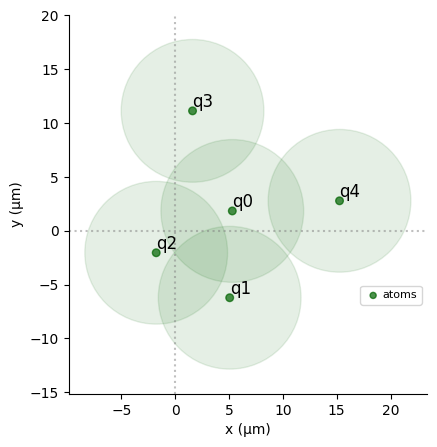

In [7]:
qubits = {f"q{i}": coord for (i, coord) in enumerate(coords)}
reg = pulser.Register(qubits)
reg.draw(
    blockade_radius=device.rydberg_blockade_radius(1.0),
    draw_graph=False,
    draw_half_radius=True,
)

Let's check that this register matches with the device's constraints by initializing the `Sequence`: 

In [8]:
sequence = pulser.Sequence(reg, device)

<div class="alert alert-warning">

**Note**:

In this case, this simple procedure was enough to give a good and valid embedding but it will not always be so. For QUBO instances that are not as easy to embbed as this one, more complex embedding strategies are required.

</div>



### 3. Pick the channels

The channel needed to implement the Ising Hamiltonian $H_Q$ is the `Rydberg.Global` channel. Let's declare this channel in the `Sequence`:

In [9]:
sequence.declare_channel("rydberg_global", "rydberg_global")

### 4. Add the Pulses

The idea behind the adiabatic algorithm (see [Albash, Lidar, 2018](https://arxiv.org/pdf/1611.04471.pdf)) is to slowly evolve the system from an easy-to-prepare groundstate to the groundstate of $H_Q$. If done slowly enough, the system of atoms stays in the instantaneous ground-state.

In our case, we continuously vary the parameters $\Omega(t), \delta(t)$ in time, starting with $\Omega(0)=0, \delta(0)<0$ and ending with $\Omega(0)=0, \delta>0$. The ground-state of $H(0)$ corresponds to the initial state $|ggggg\rangle$ and the ground-state of $H(t_f)$ corresponds to the ground-state of $H_Q$.

To ensure that we are not exciting the system to states that are too excited, we keep $\Omega \in [0, \Omega_{\text{max}}]$, and choose $\Omega_{\text{max}}$ as the median of the values of Q to ensures that the adiabatic path is efficient.

In [10]:
# We choose a median value between the min and the max
Omega = np.median(Q[Q > 0].flatten())
delta_0 = -5  # just has to be negative
delta_f = -delta_0  # just has to be positive
T = 4000  # time in ns, we choose a time long enough to ensure the propagation of information in the system

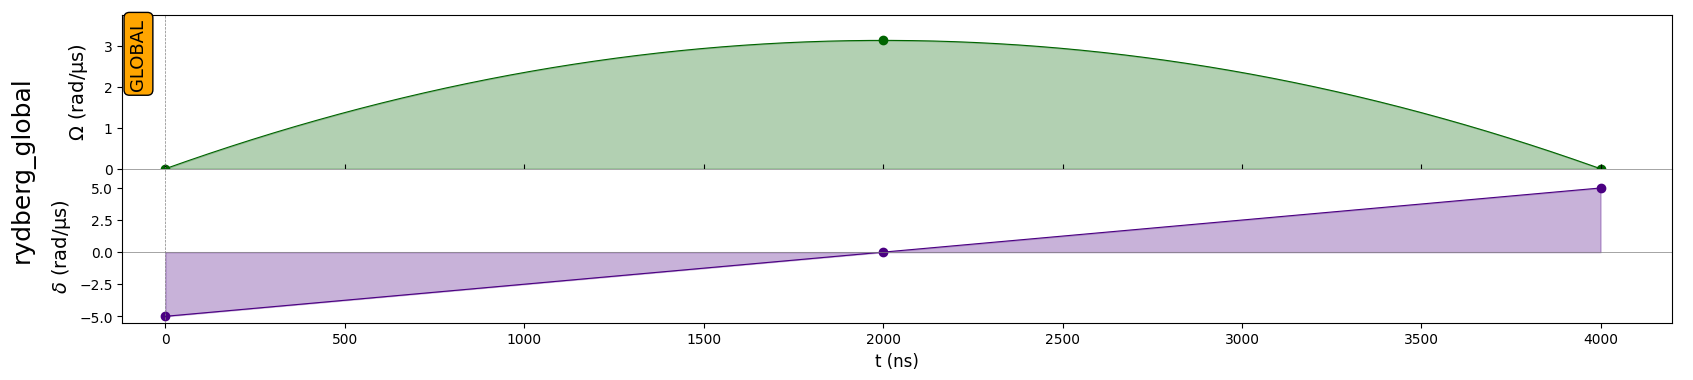

In [11]:
adiabatic_pulse = pulser.Pulse(
    pulser.InterpolatedWaveform(T, [1e-9, Omega, 1e-9]),
    pulser.InterpolatedWaveform(T, [delta_0, 0, delta_f]),
    0,
)
sequence.add(adiabatic_pulse, "rydberg_global")
sequence.draw()

In [12]:
simul = pulser_simulation.QutipBackend(sequence)
results = simul.run()
final = results.get_final_state()
count_dict = results.sample_final_state()

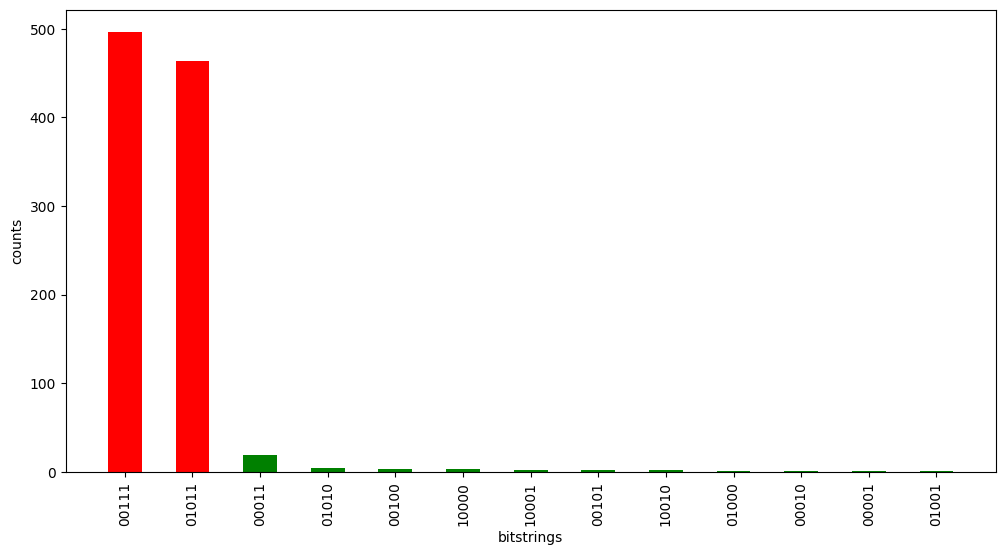

In [13]:
# Plot the distribution
count_dict = dict(
    sorted(count_dict.items(), key=lambda item: item[1], reverse=True)
)
indexes = ["01011", "00111"]  # QUBO solutions
color_dict = {key: "r" if key in indexes else "g" for key in count_dict}
plt.figure(figsize=(12, 6))
plt.xlabel("bitstrings")
plt.ylabel("counts")
plt.bar(
    count_dict.keys(),
    count_dict.values(),
    width=0.5,
    color=color_dict.values(),
)
plt.xticks(rotation="vertical")
plt.show()

The bitstrings `01011` and `00111` (in red) correspond to the two optimal solutions (calculated at the beginning of the notebook). See how fast and performant this method is! In only a few micro-seconds, we find an excellent solution.

### How does the time evolution affect the quality of the results?

The quality of a result is assessed by the cost function associated with the histogram resulting from the $N$ measurements $\{z_i: c_i\}_{1\le i\le N}$ (the $\{z_i\}$ are the measured bitstrings, the $\{c_i\}$ are the number of counts associated with each bitstring):
$$\sum_{i=1}^N \frac{c_i}{\sum_{j=1}^N c_j} z_i^TQz_i$$

Let's see how it evolves when the duration of the Sequence is increased:

In [14]:
def get_cost_colouring(bitstring, Q):
    z = np.array(list(bitstring), dtype=int)
    cost = z.T @ Q @ z
    return cost


def get_cost(counter, Q):
    cost = sum(counter[key] * get_cost_colouring(key, Q) for key in counter)
    return cost / sum(counter.values())  # Divide by total samples

In [15]:
cost = []
for T in 1000 * np.linspace(1, 10, 10):
    seq = pulser.Sequence(reg, pulser.DigitalAnalogDevice)
    seq.declare_channel("ising", "rydberg_global")
    adiabatic_pulse = pulser.Pulse(
        pulser.InterpolatedWaveform(T, [1e-9, Omega, 1e-9]),
        pulser.InterpolatedWaveform(T, [delta_0, 0, delta_f]),
        0,
    )
    seq.add(adiabatic_pulse, "ising")
    simul = pulser_simulation.QutipBackend(seq)
    results = simul.run()
    final = results.get_final_state()
    count_dict = results.sample_final_state()
    cost.append(get_cost(count_dict, Q) / 3)

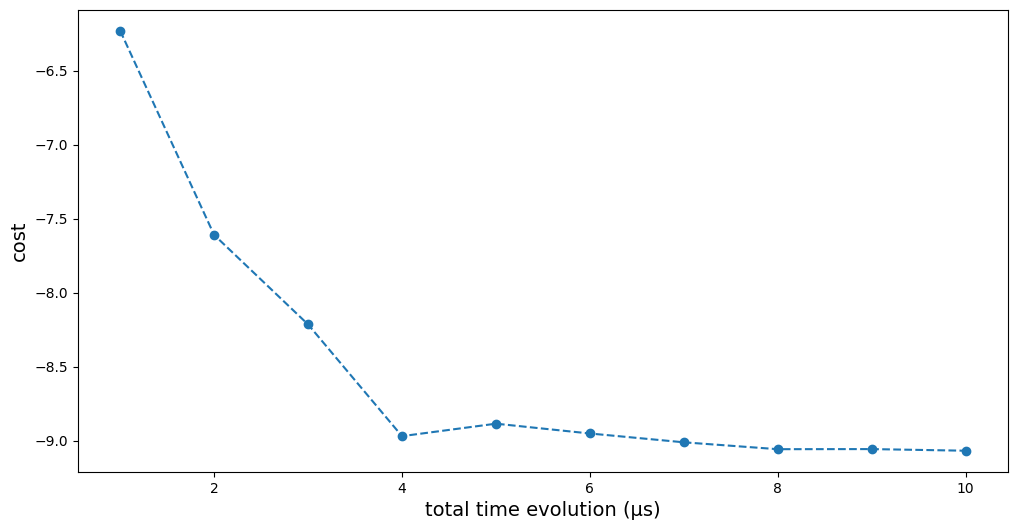

In [16]:
plt.figure(figsize=(12, 6))
plt.plot(range(1, 11), np.array(cost), "--o")
plt.xlabel("total time evolution (µs)", fontsize=14)
plt.ylabel("cost", fontsize=14)
plt.show()

We see why this approach is called "Adiabatic": the quality of the solution increases (the cost decreases) if the time taken for the evolution is longer.

<div class="alert alert-info">

**To go further**:

- The heuristic we are using here to define the values of $\Omega$ and $\delta$ along time works well in this case. You will surely have to adapt these values if you change the matrix $Q$. To tune them automatically, you can use an optimization procedure to find the sequence minimizing your cost function $z^TQz$ (see `get_cost` function above). An example of an optimization procedure is presented in [this tutorial](./tutorials/optimization.nblink) (for a different cost function).
- If the matrix $Q$ you are trying to solve contains some off-diagonal elements, you need to use local addressability to solve your problem. An example of such a problem and its solution is presented in [this tutorial](./tutorials/mwis.nblink).
</div>
